In [3]:
import numpy as np
import pandas as pd
import sklearn
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as pe

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

#nltk shit
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')

#plt settings
plt.style.use('default')
sns.set(rc={'figure.figsize':(8, 6)})
sns.set_style('white')
sns.despine()

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


<Figure size 800x600 with 0 Axes>

In [4]:
data = pd.read_csv('/content/train.csv')

In [5]:
data

,id,text,label
0,4925,We can go 4 e normal pilates after our intro...,0.0
1,2349,That seems unnecessarily affectionate,0.0
2,1396,Thats cool! I am a gentleman and will treat yo...,0.0
3,475,Nice line said by a broken heart- Plz don't cu...,0.0
4,1473,Just sent you an email – to an address with in...,0.0
...,...,...,...
4175,3838,Early bird! Any purchases yet?,0.0
4176,423,Siva is in hostel aha:-.,0.0
4177,3824,Please protect yourself from e-threats. SIB ne...,0.0
4178,1836,* Will be september by then!,0.0


In [6]:
data = data.sample(frac=1).reset_index()
data = data.drop(columns={'index', 'id'})
data

,text,label
0,True. Its easier with her here.,0.0
1,"K, can that happen tonight?",0.0
2,Miserable. They don't tell u that the side eff...,0.0
3,"It'll be tough, but I'll do what I have to",0.0
4,Nvm it's ok...,0.0
...,...,...
4175,It's é only $140 ard...É rest all ard $180 at ...,0.0
4176,Lemme know when you're here,0.0
4177,YES! The only place in town to meet exciting a...,1.0
4178,Eatin my lunch...,0.0


### **Lemmatizator**

In [7]:
lemmatizer = WordNetLemmatizer()

In [8]:
text = []
vocab = []
for i in range(len(data)):
    sentence = []
    temp = word_tokenize(data['text'].values[i])
    for word in temp:
        if word != '.':
            if word not in stopwords.words('english'):
                w = lemmatizer.lemmatize((word.lower()))
                sentence.append(w)
                if w not in vocab:
                    vocab.append(w)
    text.append(sentence)

### **overtrained word2vec**

In [9]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=text, size=2, window=30, min_count=0, workers=4, iter=120)

In [10]:
X_train = []
X_test = []
y_train = []
y_test = []

In [11]:
threshold = 500

for idx, sentence in enumerate(text):
    if len(sentence) != 0:
        wv_sentence = np.sum(model.wv[sentence], axis=0)
        if (idx < threshold):
            X_train.append(wv_sentence)
            y_train.append([data['label'].values[idx]])
        else:
            X_test.append(wv_sentence)
            y_test.append(data['label'].values[idx])

In [ ]:
X_train

### **graph with embeddings**

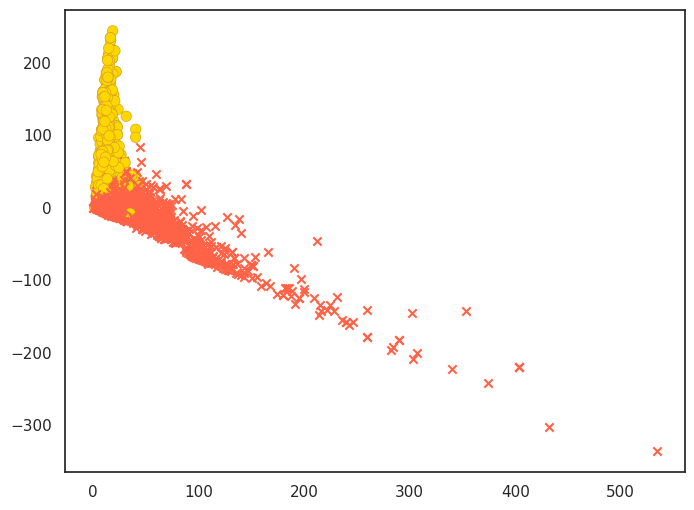

In [30]:
for i in range(len(X_test)):
    if y_test[i] == 1 and X_test[i][0] < 1400: # some blowout
        plt.scatter(X_test[i][0], X_test[i][1],
                    color='gold',
                    path_effects=[pe.Stroke(linewidth=2, foreground='goldenrod'), pe.Normal()])
    else:
        if X_test[i][0] < 1400:
            plt.scatter(X_test[i][0], X_test[i][1],
                        marker="x", 
                        color='tomato')

# plt.xlabel('x')
# plt.xlabel('y')
# plt.legend()
plt.title('')
plt.show()

### **da model Naive Bayes with big smoothing**

In [16]:
gnb = GaussianNB(var_smoothing=0.4)
gnb.fit(X_train, y_train)

GaussianNB(var_smoothing=0.4)

prediction on test set

In [17]:
pred = gnb.predict_proba(X_test)

In [18]:
# thx for the 2d array bithes (sklearn)
y_pred = []
for i in range(len(pred)):
    y_pred.append(pred[i][1])

### **roc-auc-score**

In [19]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.9873371073371073

### **test data**

In [20]:
df = pd.read_csv('/content/test.csv')
id = df['id']
df = df.drop(columns='id')

In [21]:
df

,text
0,What is the plural of the noun research?
1,"""URGENT! This is the 2nd attempt to contact U!..."
2,Ok lor.
3,Its a big difference. &lt;#&gt; versus &lt;#&g...
4,"Come to me right now, Ahmad"
...,...
1389,"As a valued customer, I am pleased to advise y..."
1390,"Yep, by the pretty sculpture"
1391,Just buy a pizza. Meat lovers or supreme. U ge...
1392,"Haha, just what I was thinkin"


### **lemmatizatiom**

In [22]:
text = []
for i in range(len(df)):
    sentence = []
    temp = word_tokenize(df['text'].values[i])
    for word in temp:
        sentence.append(lemmatizer.lemmatize((word.lower())))
    text.append(sentence)

### **word2vec embed**

In [23]:
X_pred = []
for idx, sentence in enumerate(text):
    wv_sentence = np.zeros(2)
    for word in sentence:
        if word in vocab:
            wv_sentence += model.wv[word]
    X_pred.append(wv_sentence)

### **prediction**

In [24]:
y_pred = gnb.predict_proba(X_pred)

In [25]:
pred = []
for i in range(len(y_pred)):
    pred.append(y_pred[i][1])

### **prediction**

In [26]:
ans = pd.DataFrame({'Id': id, 'Predicted': pred})

ans.to_csv('ans.csv', index = False)